In [1]:
import jax
from jax.experimental.ode import build_odeint
import jax.numpy as np
# this config to use 64-bit floats is needed for scipy minimize to work correctly
# https://github.com/google/jax/issues/936
from jax.config import config
config.update("jax_enable_x64", True)
import datetime as DT
from matplotlib.dates import date2num, num2date
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import minimize
import pandas as pd

In [12]:
# helper function for date formatting on the plots
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 22}
matplotlib.rc('font', **font)

def format_date(x, pos=None):
        thisind = np.clip(int(startInd + x + 0.5), startInd, startInd + numTimes - 1)
        return num2date(times[thisind]).strftime('%m/%d/%Y')

In [3]:
# Fetch US data from NYTimes
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
df = pd.read_csv(url, parse_dates=['date'], dtype={'fips': str})
df

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061,1,0
1,2020-01-22,Snohomish,Washington,53061,1,0
2,2020-01-23,Snohomish,Washington,53061,1,0
3,2020-01-24,Cook,Illinois,17031,1,0
4,2020-01-24,Snohomish,Washington,53061,1,0
...,...,...,...,...,...,...
17726,2020-03-28,Sheridan,Wyoming,56033,6,0
17727,2020-03-28,Sublette,Wyoming,56035,1,0
17728,2020-03-28,Sweetwater,Wyoming,56037,1,0
17729,2020-03-28,Teton,Wyoming,56039,14,0


In [4]:
# Reduce to just Cook County, IL data from March, 2020 onwards
df = df[(df.fips == "17031") & (df.date >= "2020-03-01")]
df

,date,county,state,fips,cases,deaths
413,2020-03-01,Cook,Illinois,17031,3,0
443,2020-03-02,Cook,Illinois,17031,4,0
477,2020-03-03,Cook,Illinois,17031,4,0
512,2020-03-04,Cook,Illinois,17031,4,0
554,2020-03-05,Cook,Illinois,17031,5,0
612,2020-03-06,Cook,Illinois,17031,6,0
696,2020-03-07,Cook,Illinois,17031,6,0
793,2020-03-08,Cook,Illinois,17031,7,0
913,2020-03-09,Cook,Illinois,17031,11,0
1054,2020-03-10,Cook,Illinois,17031,17,0


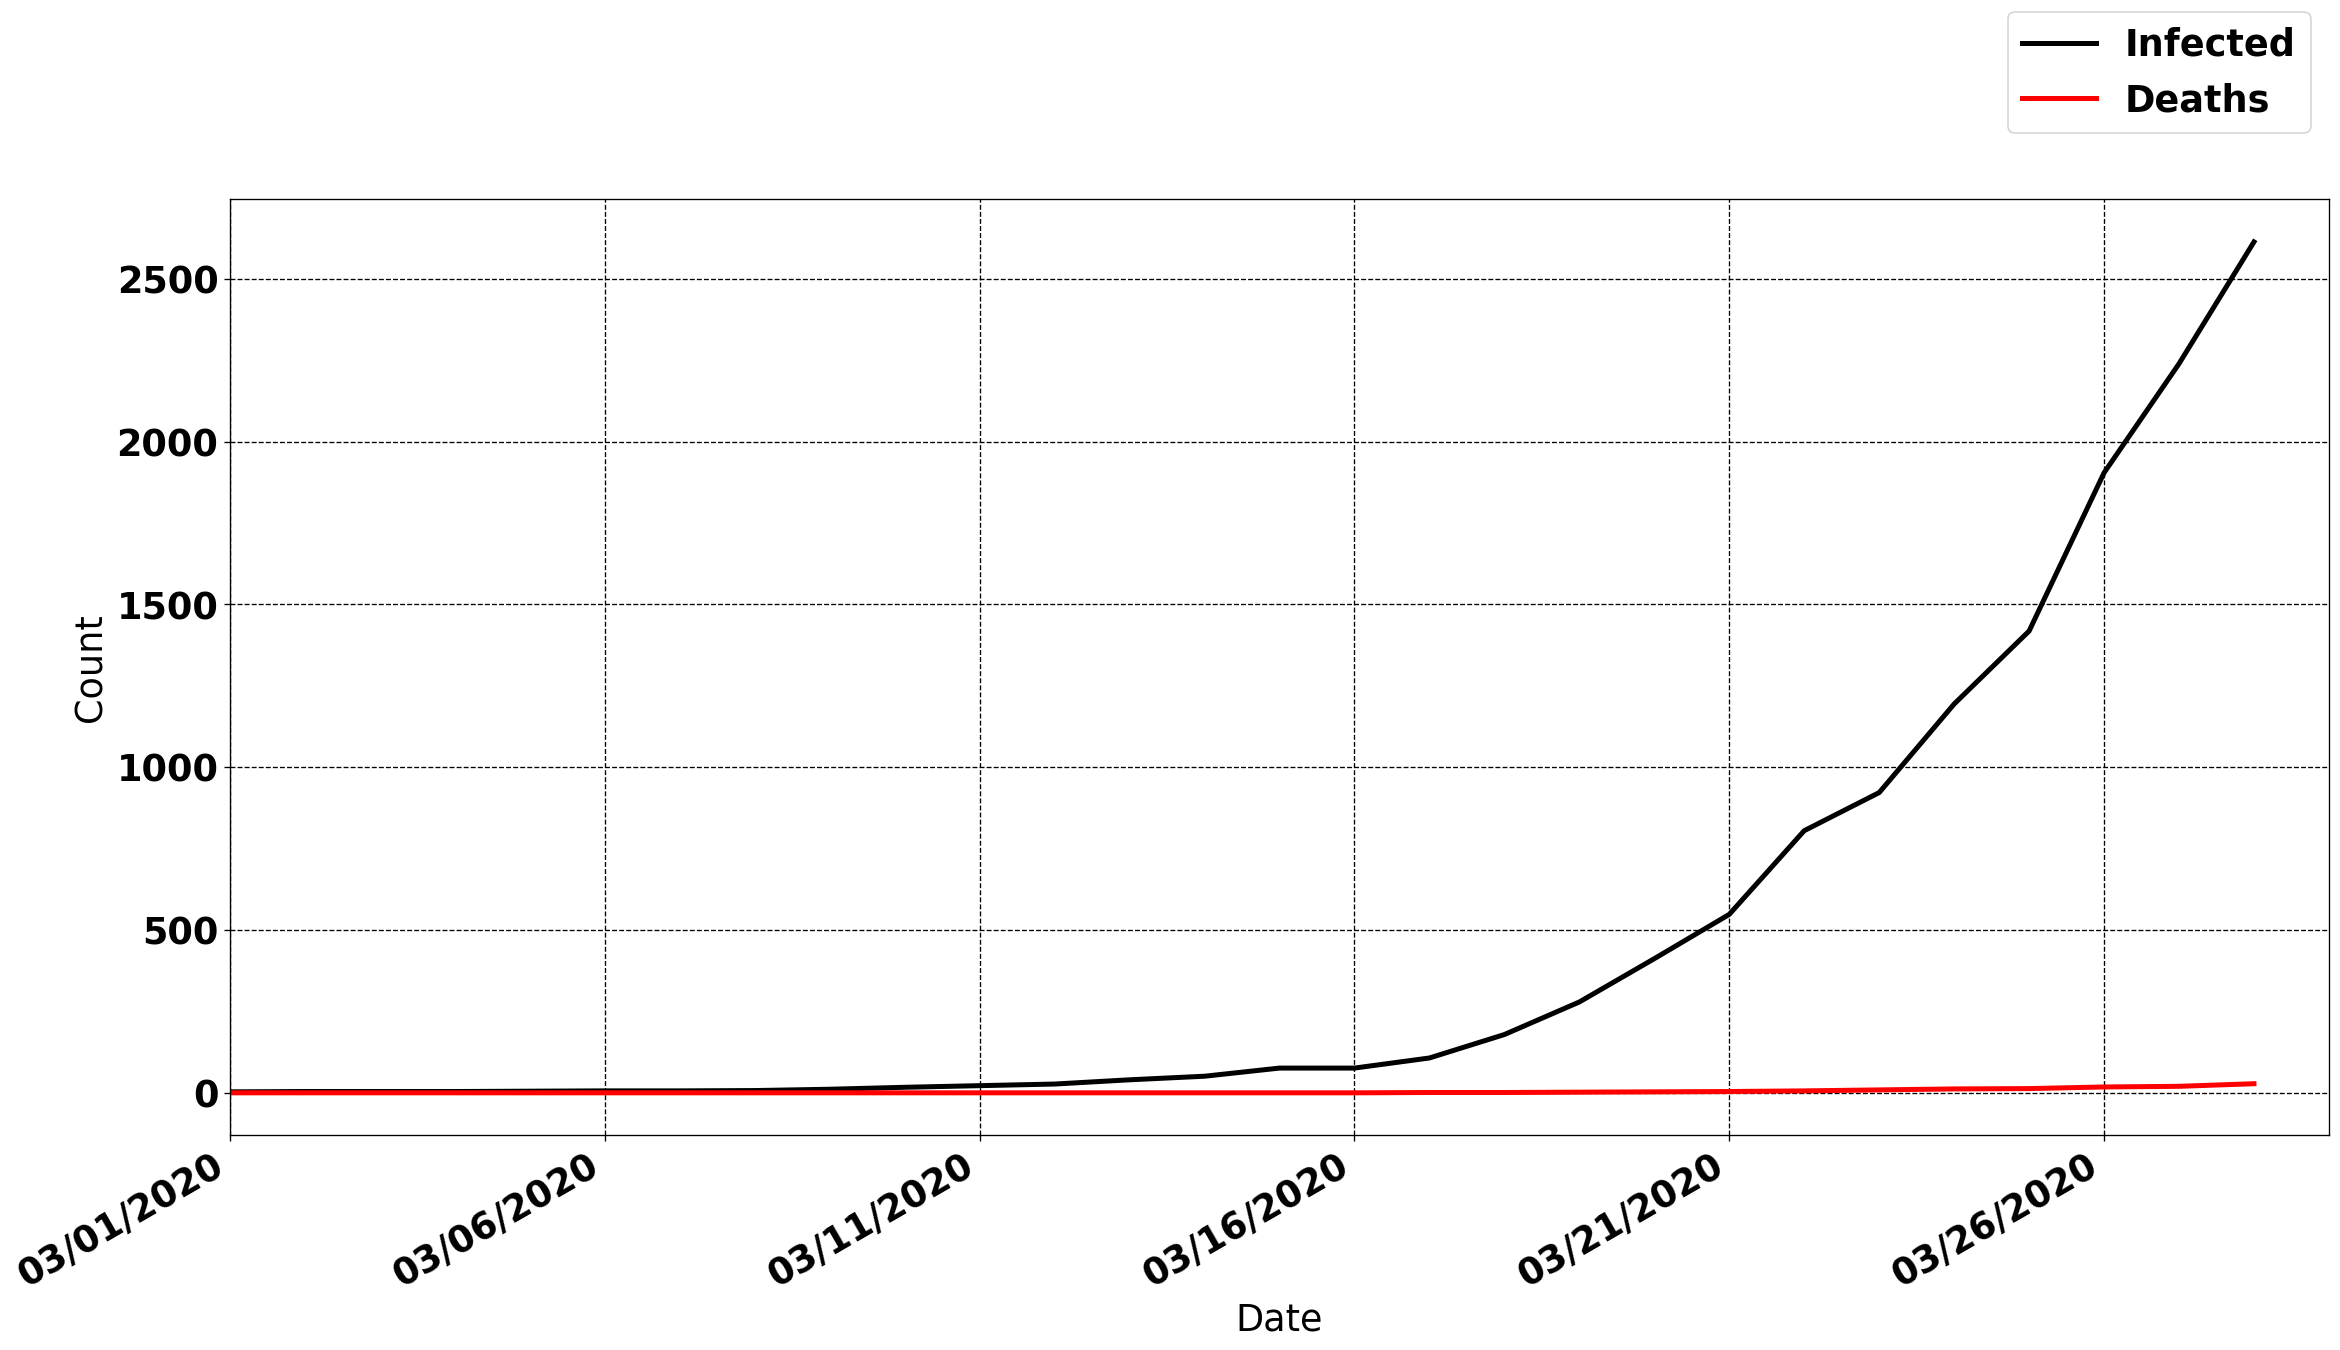

In [5]:
# Make a plot of the observed data

observed_infected = df.cases
observed_deaths = df.deaths
observed_times = [date2num(s) for (s) in df.date]

# for plotting the dates well
startInd = 0
times = observed_times
numTimes = len(times)


fig = plt.figure(figsize=[22, 12], dpi=120)
fig.subplots_adjust(top=0.85,right=0.92)
ind = np.arange(numTimes)

ax = fig.add_subplot(111)
ax.yaxis.grid(True, color='black', linestyle='dashed')
ax.xaxis.grid(True, color='black', linestyle='dashed')
ax.set_axisbelow(True)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_date))
fig.autofmt_xdate()

infectedp, = ax.plot(ind, observed_infected, linewidth=3, color='black')
deathsp, = ax.plot(ind, observed_deaths, linewidth=3, color='red')
ax.set_xlim(0, numTimes)
#ax.set_ylim(0, dataMax)
ax.set_xlabel('Date')
ax.set_ylabel('Count')

plt.legend([infectedp, deathsp], ["Infected", "Deaths"], loc='upper right', bbox_to_anchor=(1, 1.22), fancybox=True)
fig.show()

In [6]:
# SIR Model from https://www.who.int/bulletin/online_first/20-255158.pdf
def dx_dt(x, t, beta, gamma):
    S, I, R = x
    N = S + I + R

    dS_dt = - (beta * S * I) / N
    dI_dt = ((beta * S * I) / N) - (gamma * I)
    dR_dt = gamma * I

    return np.stack([dS_dt, dI_dt, dR_dt])

SIR = build_odeint(dx_dt)

In [22]:
# Run simultation an initial simulation for Cook County, IL, USA
num_days = 180
population = 5180493.0
I = observed_infected.values[0]
S = population - I
R = 0.0
x_init = 1.0 * np.array([S, I, R])
t = np.arange(num_days, dtype='float64')
# initial guesses
beta = 0.1582
gamma = 0.0002
x = SIR(x_init, t, beta, gamma)

In [23]:
# Make a plot of the example SIR model
def plot_modeled(modeled_infected, modeled_recovered, modeled_susceptible):
    global times, numTimes
    startInd = 0
    numTimes = len(times)

    fig = plt.figure(figsize=[22, 12], dpi=120)
    fig.subplots_adjust(top=0.85, right=0.92)
    ind = np.arange(numTimes)
    indObs = np.arange(len(observed_infected))

    ax = fig.add_subplot(111)
    ax.yaxis.grid(True, color='black', linestyle='dashed')
    ax.xaxis.grid(True, color='black', linestyle='dashed')
    ax.set_axisbelow(True)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_date))
    fig.autofmt_xdate()

    infectedp, = ax.plot(indObs, observed_infected, linewidth=3, color='black')
    sp, = ax.plot(ind, modeled_susceptible, linewidth=3, color='orange')
    ip, = ax.plot(ind, modeled_infected, linewidth=3, color='blue')
    rp, = ax.plot(ind, modeled_recovered, linewidth=3, color='green')
    ax.set_xlim(0, numTimes)
    #ax.set_ylim(0, dataMax)
    ax.set_xlabel('Date')
    ax.set_ylabel('Count')
    #ax.ticklabel_format(useOffset=False, style='plain', axis='y')
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

    plt.legend([infectedp, sp, ip, rp], ["Observed Infected", "Modeled Susceptible", "Modeled Infected", "Modeled Recovered"], loc='upper right', bbox_to_anchor=(1, 1.22), fancybox=True)
    fig.show()

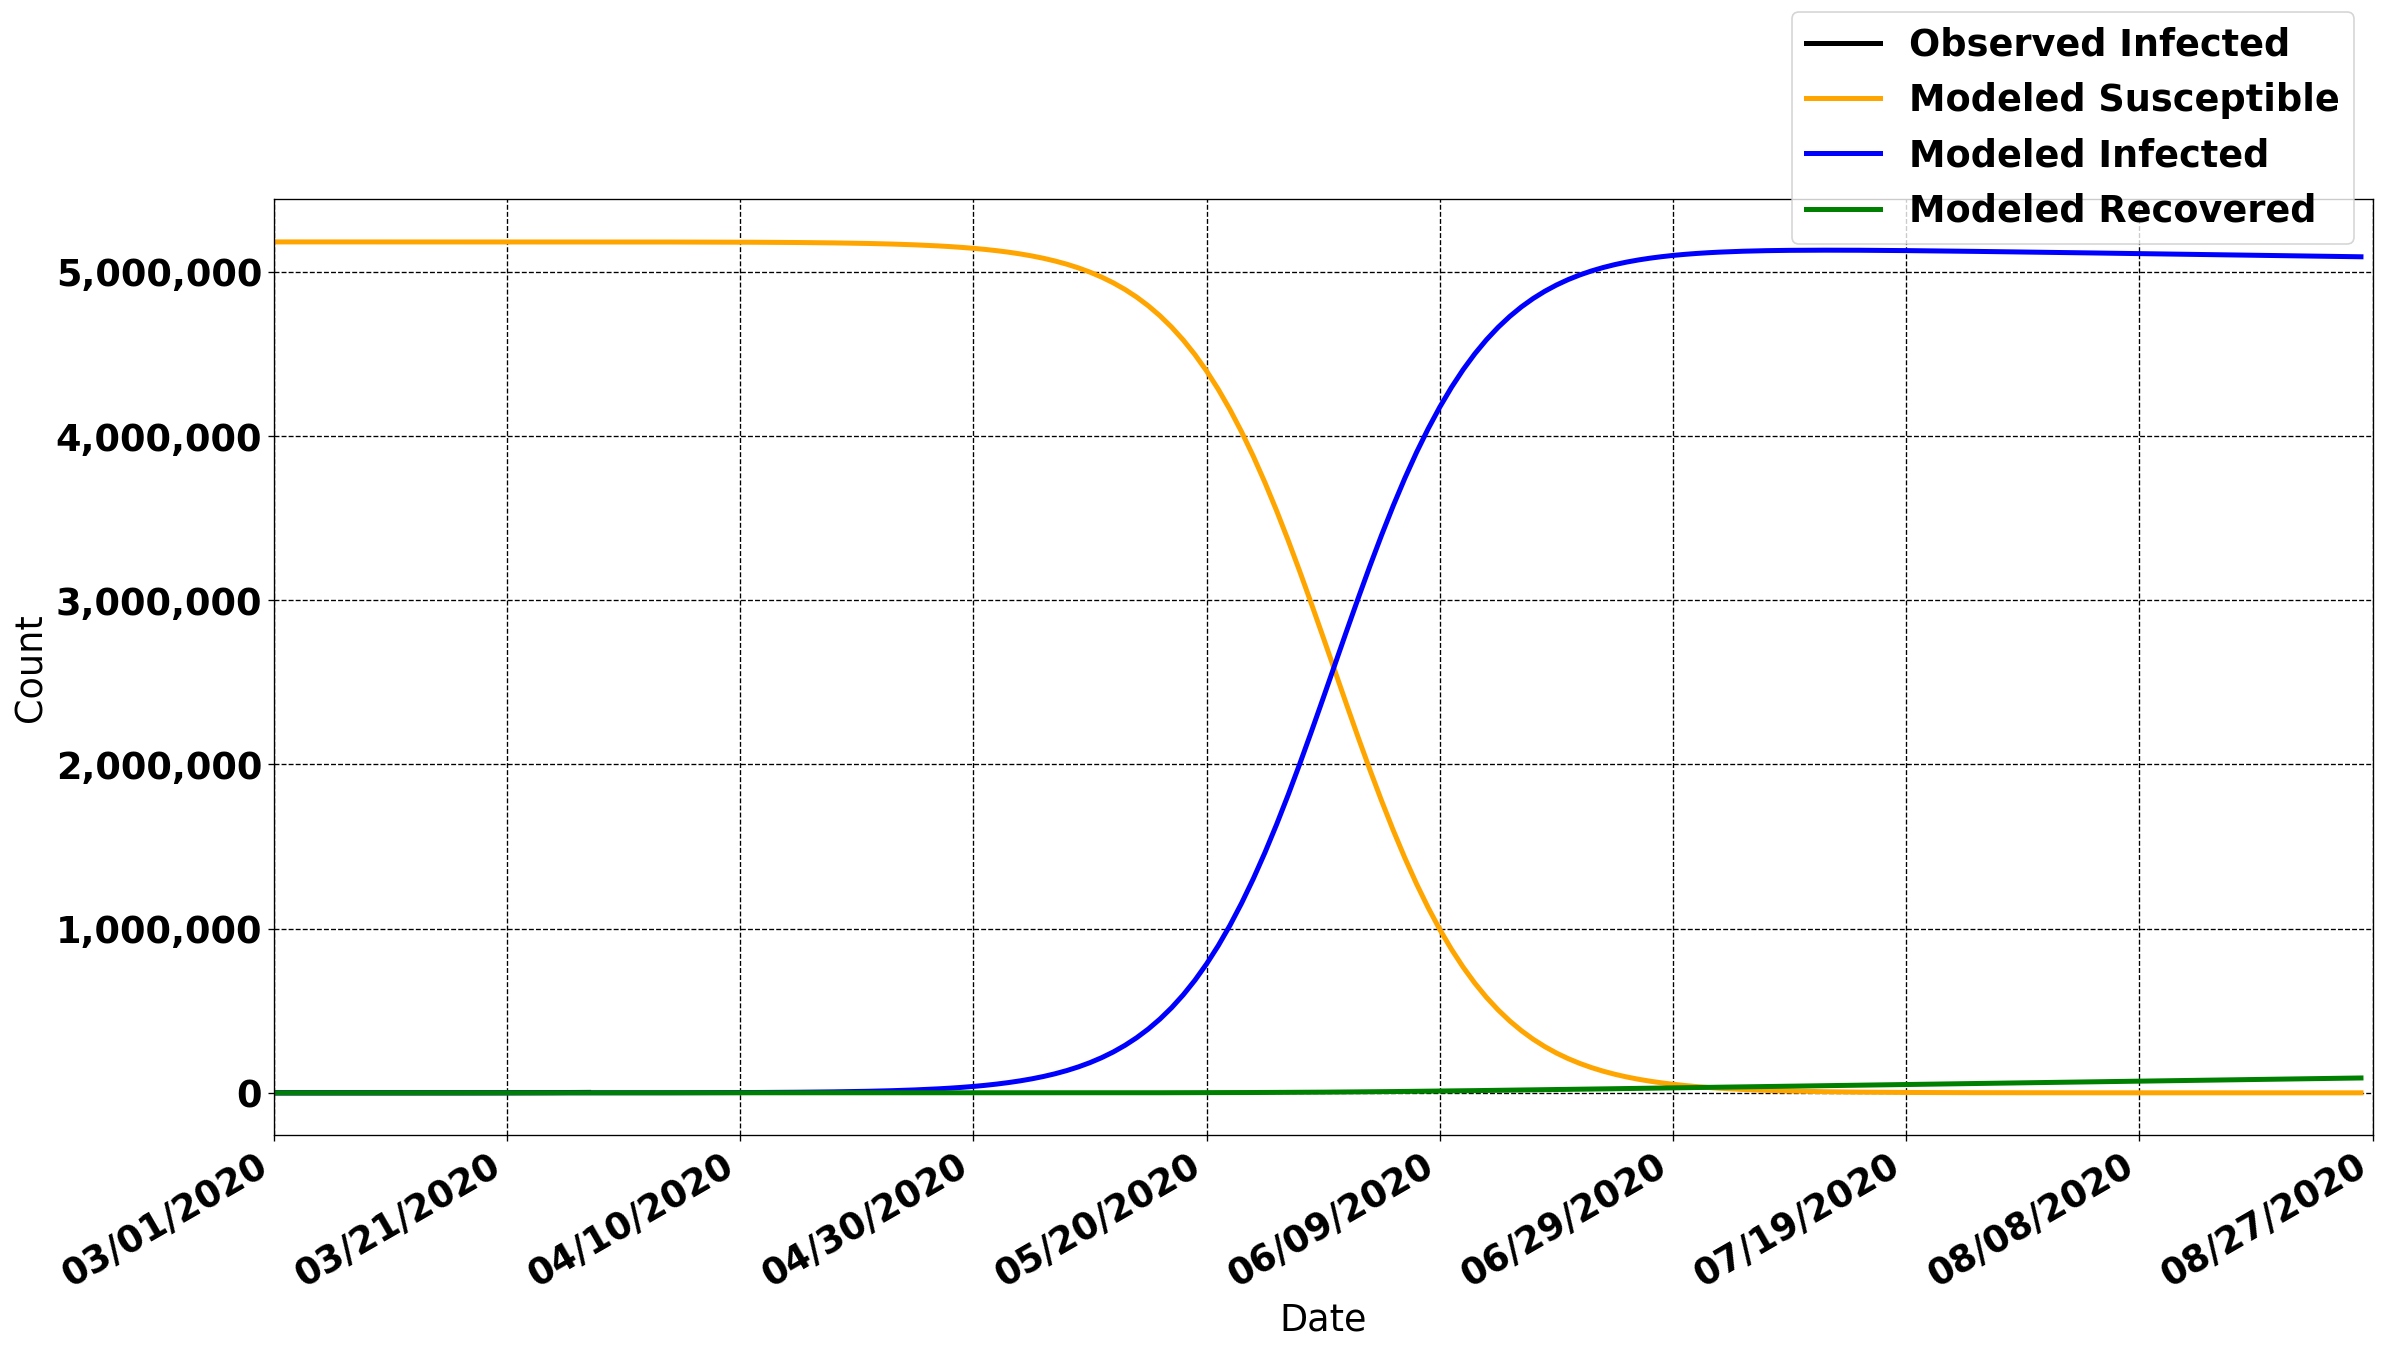

In [24]:
times = t + observed_times[0]
plot_modeled(x[:, 1], x[:, 2], x[:, 0])

In [25]:
# optimize beta & gamma

def loss(guess, x_init, t, observed_infected):
    beta, gamma = guess
    x = SIR(x_init, t, beta, gamma)
    return np.sqrt(np.mean((x[:, 1] - observed_infected)**2))

num_days = len(observed_infected.values)
I = observed_infected.values[0]
S = population - I
R = 0.0
x_init = 1.0 * np.array([S, I, R])
t = np.arange(num_days, dtype='float64')

best = minimize(loss, [0.15, 0.001], args=(x_init, t, observed_infected.values), method='L-BFGS-B', bounds=[(0.00000001, 0.6), (0.00000001, 0.6)])

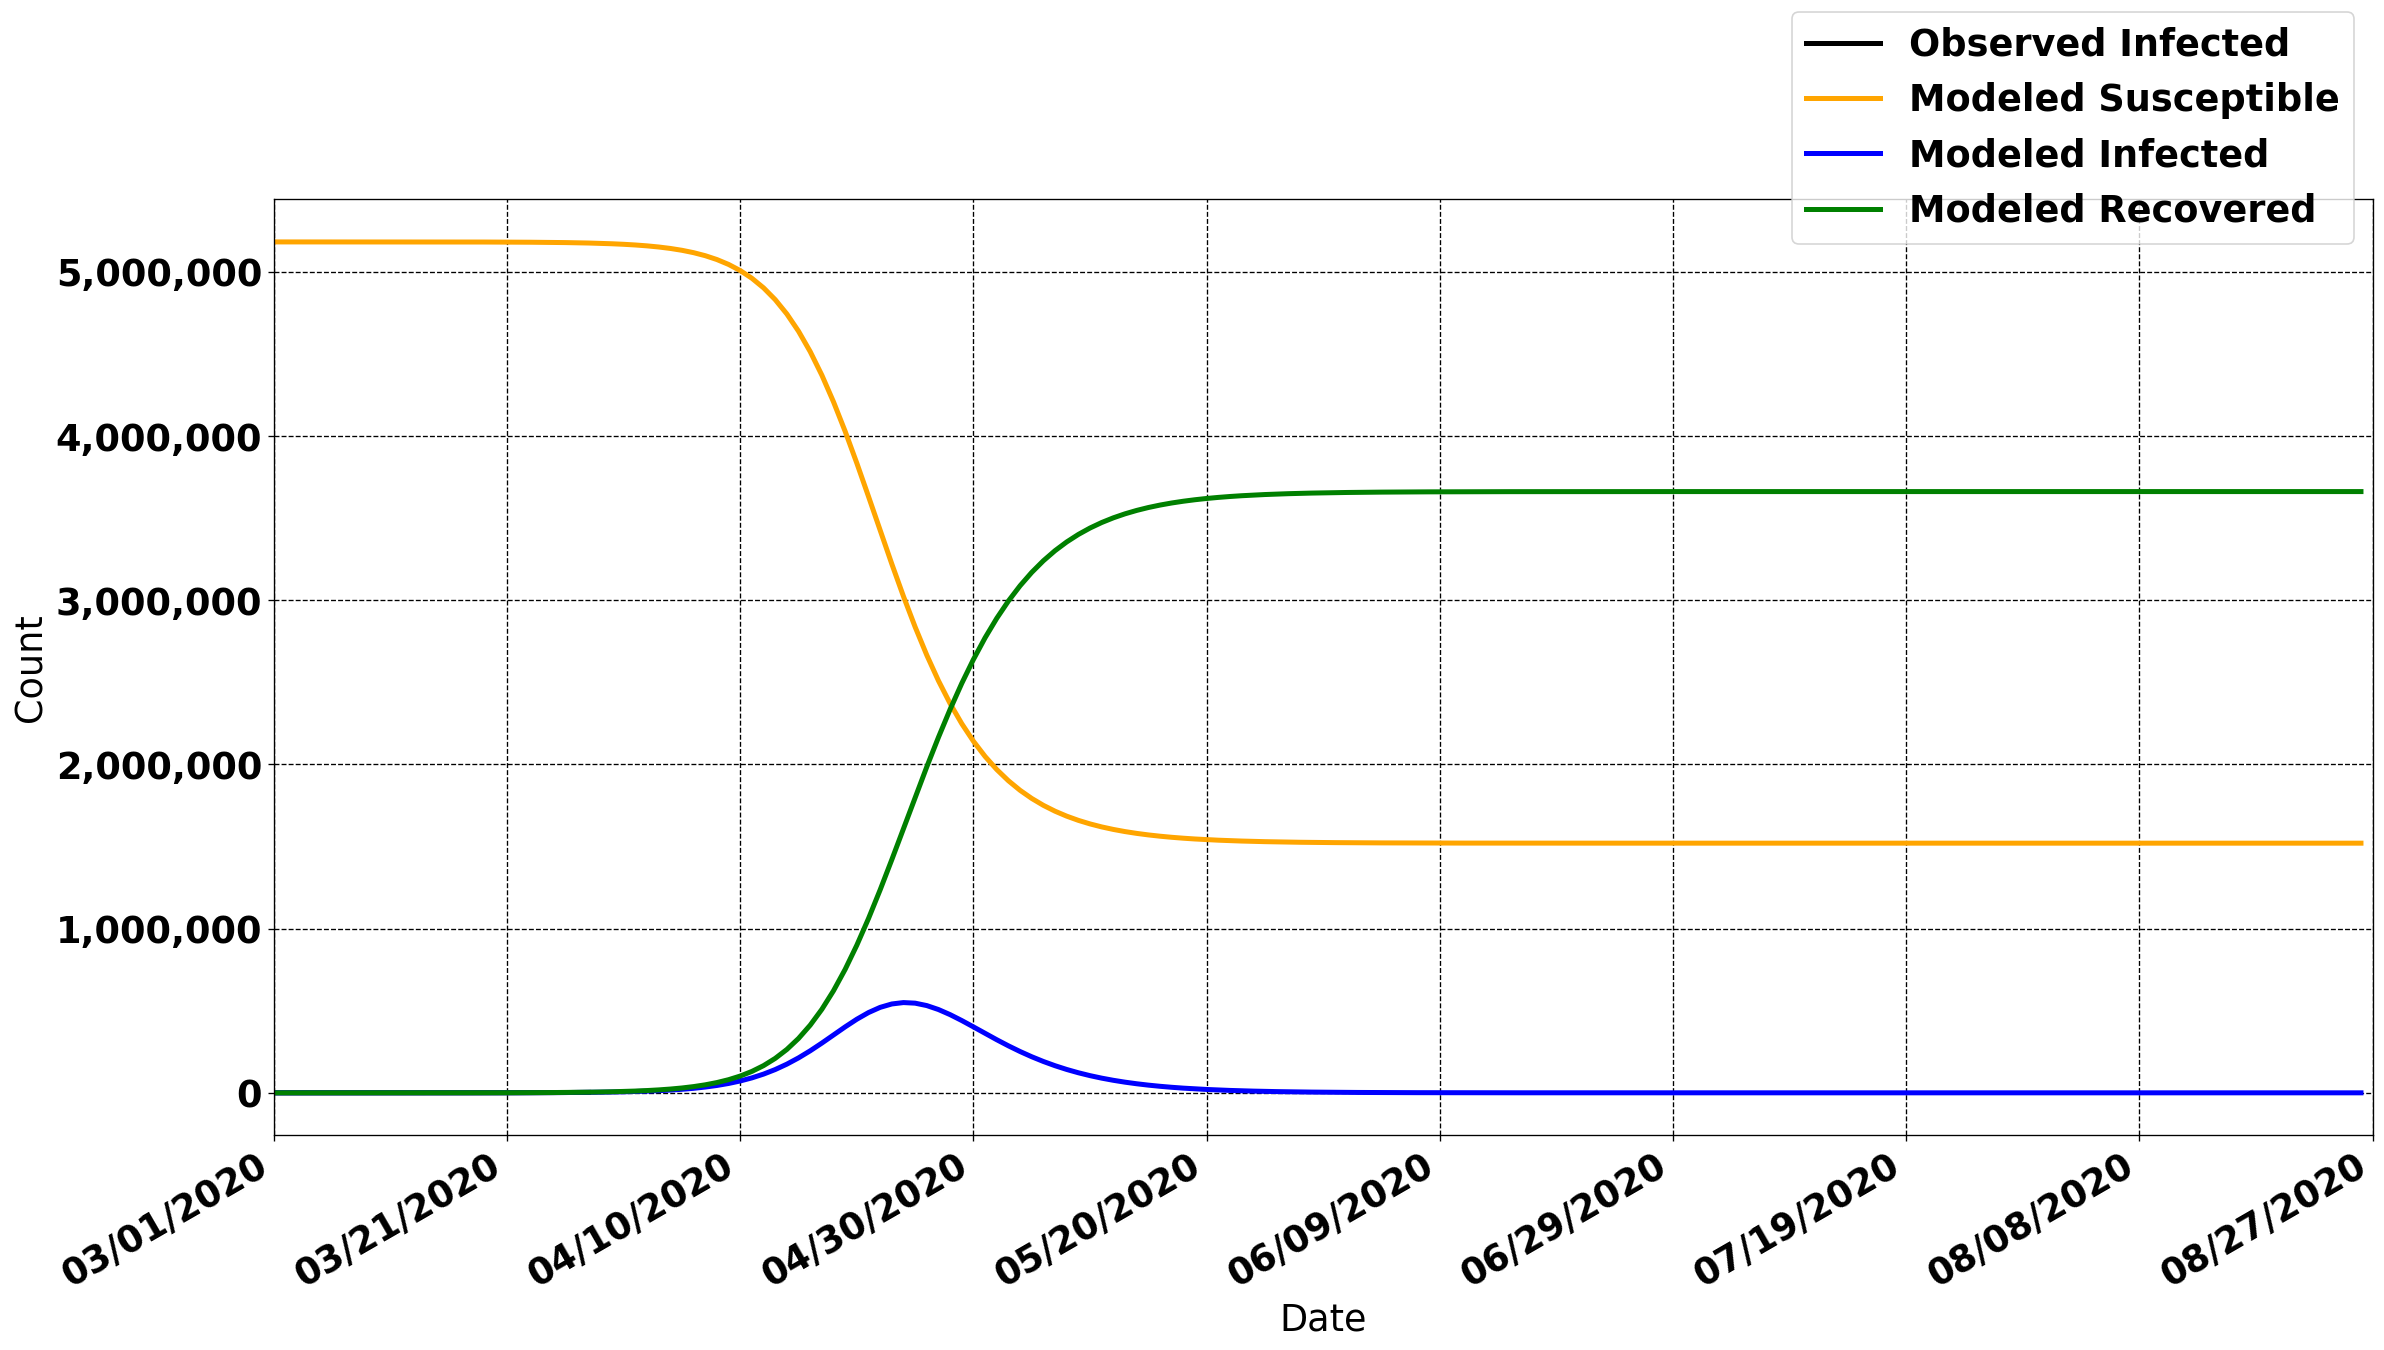

In [26]:
# Plot Optimized SIR model
num_days = 180
I = observed_infected.values[0]
S = population - I
R = 0.0
x_init = 1.0 * np.array([S, I, R])
t = np.arange(num_days, dtype='float64')
beta, gamma = best.x
x = SIR(x_init, t, beta, gamma)
times = t + observed_times[0]
plot_modeled(x[:, 1], x[:, 2], x[:, 0])